### Multiresolution regression of a function with non-continuous derivative

**Author**: Daniele E. Schiavazzi

**Date**: June 28th, 2017

**References**
- Schiavazzi D., Doostan A., Iaccarino G. and Marsden A.L., **A Generalized Multi-resolution Expansion for Uncertainty Propagation with Application to Cardiovascular Modeling**, *Computer Methods in Applied Mechanics and Engineering*, 314(1):196-221, 2017. [Link](http://www.sciencedirect.com/science/article/pii/S0045782516311951)
- Schiavazzi D., Doostan A. and Iaccarino G., **Sparse multiresolution regression for uncertainty propagation**, *International Journal for Uncertainty Quantification*, 4(4):303-331, 2014. [Link](http://www.dl.begellhouse.com/journals/52034eb04b657aea,670f36d96da30eed,699d886b45d6b358.html)

**Objectives of this tutorial**:
- Introduce **multiwavelet basis** for stochastic regression.
- Show **how to play with the parameters** needed to generate these functions.
- **Demonstrate application in regression** for a simple 1D function with discontinuous derivative.

In [1]:
# Imports
import sys,math
sys.path.insert(0, '..') # path to ../common.py
import numpy as np
import matplotlib.pyplot as plt
from common import *

Let's first define a simple function
$$
f(x) = \frac{1.0}{\vert 0.25 - x^2\vert + 0.1}
$$
defined in the $[0,1]$ interval, with discontinuous slope at 0.5. Let's plot it to see what it looks like.


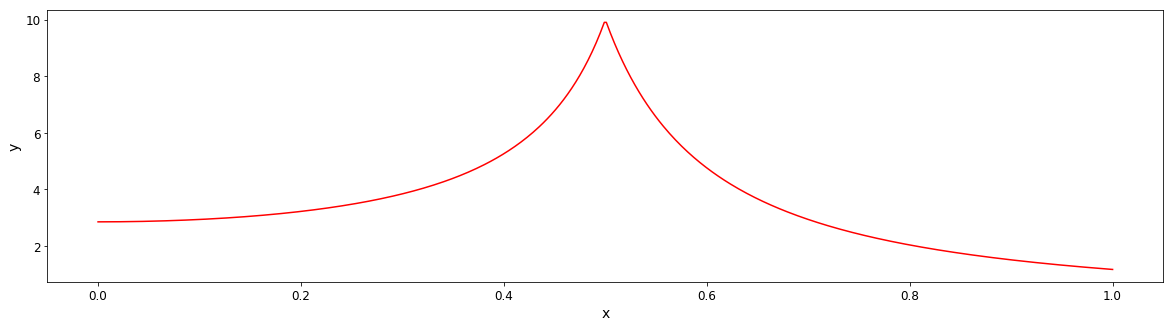

In [2]:
# Model Function
def runModel(xVals):
  return 1.0/(np.fabs(0.25 - np.square(xVals))+0.1)

# Plot a stochastic response with steep gradients
xExact = np.arange(500)/499.0
yExact = runModel(xExact)

# Plot Function
plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
plt.plot(xExact,yExact,'r-')
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

Define a **flag** to switch between random and equally spaced sampling points. This allows to quickly check what happens using random instead of equally spaced points and by changing their number.

In [3]:
# Flag for random points
useRandomLocs = False
numberOfSampels = 41

# Random Polynomial OLS Regression 
np.random.seed(0)
if(useRandomLocs):
  xVals = np.sort(np.random.rand(numberOfSampels))
else:
  xVals = np.arange(numberOfSampels)/float(numberOfSampels-1)
yVals = runModel(xVals)

Let's visualize the selected sampling points

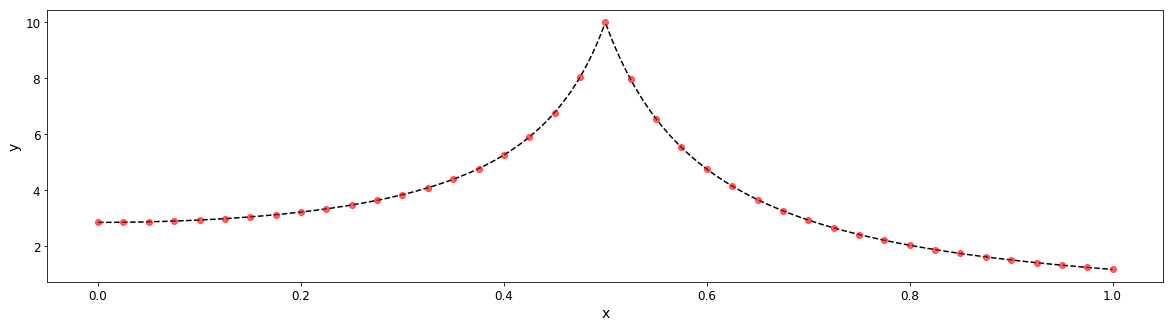

In [4]:
# Plot Function
plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
plt.plot(xExact,yExact,'k--')
plt.plot(xVals,yVals,'ro',markersize=6,alpha=0.6)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

Since we would like to perform regression with Legendre polynomials first, **we need to scale** xVals to fit in the $[-1,1]$ interval.

In [5]:
# Normalize Inputs
xTrain = np.resize(2.0*xVals - 1.0,(len(xVals),1))

We want to perform regression using [Relevance Vector Machine](http://www.jmlr.org/papers/volume1/tipping01a/tipping01a.pdf) regression. So once again we initialize the associated python class **as for the previous tutorial**.

In [6]:
# Init RVM Object
rvm = tulipRVM()

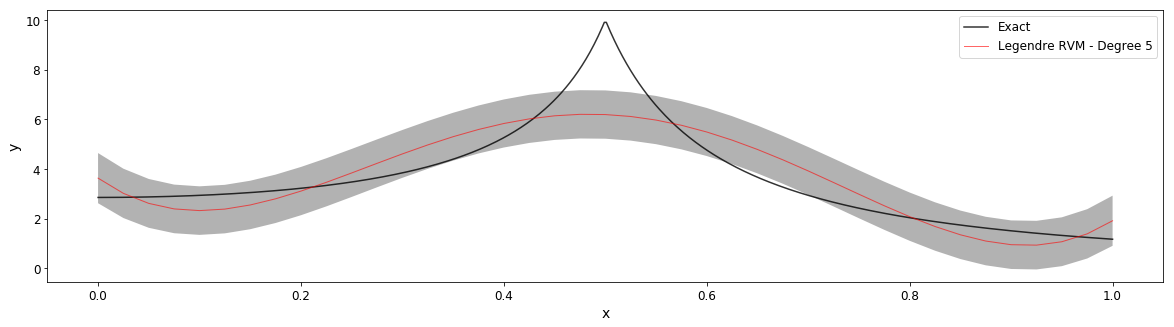

In [7]:
# Make Polynomial Regressions with RVM using polynomials of order 5
measMat = buildRegressionMatrix(xTrain,5)
rvmCoeffs,rvmCoeffsCov,rvmNoise = rvm.train(measMat,yVals)

# Compute the average reconstructed Qtys
rvmY = np.dot(np.array(measMat.getMatrix()),rvmCoeffs)
# Compute the uncertainty region
rvmAux = np.dot(np.dot(np.array(measMat.getMatrix()),rvmCoeffsCov),np.array(measMat.getMatrix()).transpose())
rvmSTDQ = rvmNoise + np.sqrt(np.diag(rvmAux))

plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
plt.plot(xExact,yExact,'k-',alpha=0.8,label='Exact')
plt.plot(xVals,rvmY,'r-',alpha=0.6,lw=1.0,label='Legendre RVM - Degree 5')
plt.fill_between(xVals,rvmY+rvmSTDQ, rvmY-rvmSTDQ,facecolor='gray',interpolate=True,alpha=0.6)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(fontsize=12)
plt.show()

Let's increase the order of the polynomials regression to **30**.

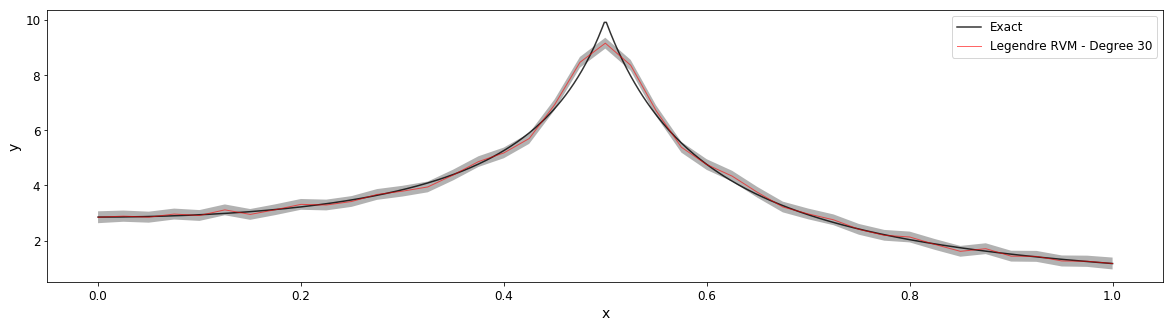

In [8]:
# Make Polynomial Regressions with RVM using polynomials of order 30
measMat = buildRegressionMatrix(xTrain,30)
rvmCoeffs,rvmCoeffsCov,rvmNoise = rvm.train(measMat,yVals)

# Compute the average reconstructed Qtys
rvmY = np.dot(np.array(measMat.getMatrix()),rvmCoeffs)
# Compute the uncertainty region
rvmAux = np.dot(np.dot(np.array(measMat.getMatrix()),rvmCoeffsCov),np.array(measMat.getMatrix()).transpose())
rvmSTDQ = rvmNoise + np.sqrt(np.diag(rvmAux))

plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
plt.plot(xExact,yExact,'k-',alpha=0.8,label='Exact')
plt.plot(xVals,rvmY,'r-',alpha=0.6,lw=1.0,label='Legendre RVM - Degree 30')
plt.fill_between(xVals,rvmY+rvmSTDQ, rvmY-rvmSTDQ,facecolor='gray',interpolate=True,alpha=0.6)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(fontsize=12)
plt.show()


### Rudiments of Multiresolution analysis and multiwavelet basis

#### Multiresolution analysis

A **multiresolution** approximation of $\mathbf{L}^2([0,1])$ is expressed by means of a nested sequence of closed subspaces $\mathbf{V}_{0}\subset\mathbf{V}_{1}\subset\dots\subset\mathbf{V}_{j}\subset\dots\subset\mathbf{L}^2([0,1])$, where each subspace $\mathbf{V}_j$ corresponding to **resolution** $j$ is given by $\mathbf{V}_j = \mathrm{span}\{\phi_{j,k}(y): k = 0,\dots,2^{j}-1\}$. 

Here, the functions

$$
\phi_{j,k}(y)=2^{j/2}\phi(2^{j}y-k)
$$

are dilations and translations of a **scaling** function $\phi(y):[0,1]\rightarrow\mathbb{R}$, and $\phi(y)$ is such that the closure of the union of $\mathbf{V}_{j}$, $\overline{\bigcup_{k=0}^{\infty}\mathbf V_k}$, is dense in $\mathbf{L}^2([0,1])$. 

Let the **wavelet** subspace $\mathbf W_j$ denote the orthogonal complement of $\mathbf{V}_{j}$ in $\mathbf{V}_{j+1}$, that is $\mathbf V_{j+1} = \mathbf{V}_{j} \oplus \mathbf W_j$ and $\mathbf{V}_{j}\bot \mathbf W_j$. It can be shown that $\mathbf W_j = \mathrm{span}\{\varphi_{j,k}(y):k = 0,\dots,2^{j}-1\}$ where $\varphi_{j,k}(y)$ is generated from dilation and translation of a so-called **mother wavelet** function $\varphi(y):[0,1]\rightarrow\mathbb{R}$,

$$
\varphi_{j,k}(y) = 2^{j/2}\varphi(2^{j}y-k). 
$$
 
By the construction of wavelet subspaces $\mathbf W_j$, it is straightforward to see that $\mathbf V_{j} = \mathbf V_0 \oplus\left(\bigoplus_{k=0}^{j-1}\mathbf W_k\right)$, and consequently $\mathbf V_0 \oplus\left(\bigoplus_{k=0}^{\infty}\mathbf W_k\right)=\mathbf{L}^2([0,1])$. Therefore, any function $u(y)\in \mathbf{L}^2([0,1])$ admits an orthogonal decomposition of the form

$$
u(y) = \tilde{\alpha}_{0,0}\phi_{0,0}(y) + \sum_{j=0}^{\infty}\sum_{k=0}^{2^{j}-1} \alpha_{j,k} \varphi_{j,k}(y), 
$$

where $\tilde{\alpha}_{0,0} = \langle u,\phi_{0,0} \rangle_{\mathbf{L}^2([0,1])}$, $\alpha_{j,k}= \langle u,\varphi_{j,k} \rangle_{\mathbf{L}^2([0,1])}$, and the inner-product $\langle u,v \rangle_{\mathbf{L}^2([0,1])} = \int_{0}^{1}u(y)\,v(y)\,dy$.

For the interest of notation, we rewrite the above expansion of $u(y)$ as

$$
u(y) = \sum_{i=1}^{\infty}\alpha_{i} \psi_{i}(y), 
$$

in which we establish a one-to-one correspondence between elements of the basis sets $\{\phi_{0,0},\varphi_{j,k}:k = 0,\dots,2^{j}-1, j = 0,\dots,\infty \}$ and $\{\psi_i:i = 1,\dots,\infty\}$.


#### Multiwavelet basis in one dimension


In the present study, we adopt the multiresolution basis of [Alpert](http://epubs.siam.org/doi/abs/10.1137/0524016), where multiple scaling functions $\{\phi_i(y): i = 0,\dots,m-1\}$ are used to construct the polynomial space $\mathbf{V}^{m}_{0}$. 

Specifically, we choose $\phi_i(y)$ as the Legendre polynomial of degree $i$ defined on $[0,1]$. 
An orthonormal piecewise polynomial basis $\{\varphi_i(y)\in\mathbf{L}^2([0,1]): i = 0,\dots,m-1\}$ of $\mathbf{W}^{m}_{0}$ is also established such that

$$
\int_{0}^{1}\varphi_i(y)y^l dy = 0,\qquad i,l=0,\cdots,m-1.
$$

Let $\mathbf{U}_z = \{u(y)\in\mathbf{L}^2([-1,1]): \int^{1}_{-1}u(y)\,y^{z}\,dy=0\}$ represent the subspace of functions supported on the interval $[-1,1]$ with $z$ vanishing moments. 

Given a maximum polynomial degree $m$, we construct $\{f_i:\,i=0,\dots,m-1\}$ in steps:

- Start from monomials of increasing degree, discontinuous and opposite in sign on the sub-intervals $[-1,0)$ and $[0,1]$.

- Require that $f_i\in\mathbf{U}_{j}$, $j=0,\dots,i+m-1$.

- Enforce orthogonality, i.e., $\langle f_i,f_j\rangle_{\mathbf{L}^2[(0,1)]}=\delta_{ij}$, $i,j = 0,\dots,m-1$, where $\delta_{ij}$ is the Kronecker delta. 

- Finally compute $\{\varphi_i(y): i = 0,\dots,m-1\}$ by normalization $\{f_i:\,i=0,\dots,m-1\}$ on the interval $[0,1]$.

The **multiwavelet** basis functions $\varphi_{j,i,k}(y)$, hence the multiwavelet subspaces $\mathbf{W}^{m}_j$, are generated by dilations and translations of $\{\varphi_i(y): i = 0,\dots,m-1\}$, that is

$$
\varphi_{j,i,k}(y) = 2^{j/2}\varphi_i(2^j y-k),\quad i=0,\cdots,m-1,\; k=0,\cdots,2^j-1.
$$

With certain additional constraints on $\varphi_i(y)$, the resulting basis is **unique (up to the sign)** and provides a **generalization of the Legendre and Haar basis**. 
In particular, the Legendre polynomials may be obtained by limiting the resolution to $j=0$, while Haar wavelets are obtained by setting $m=1$.

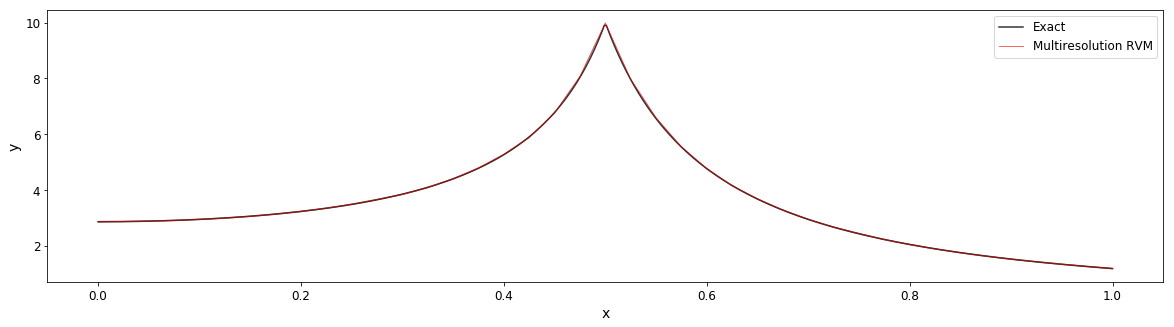

In [9]:
# Make Polynomial Regressions with RVM
maxOrder = 3
maxDetailLevel = 2
measMat = buildMultiresolutionMatrix(np.resize(xVals,(len(xVals),1)),maxOrder,maxDetailLevel)
rvmCoeffs,rvmCoeffsCov,rvmNoise = rvm.train(measMat,yVals)

# Compute the average reconstructed Qtys
rvmY = np.dot(np.array(measMat.getMatrix()),rvmCoeffs)
# Compute the uncertainty region
rvmAux = np.dot(np.dot(np.array(measMat.getMatrix()),rvmCoeffsCov),np.array(measMat.getMatrix()).transpose())
rvmSTDQ = rvmNoise + np.sqrt(np.diag(rvmAux))

plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
plt.plot(xExact,yExact,'k-',alpha=0.8,label='Exact')
plt.plot(xVals,rvmY,'r-',alpha=0.6,lw=1.0,label='Multiresolution RVM')
plt.fill_between(xVals,rvmY+rvmSTDQ, rvmY-rvmSTDQ,facecolor='gray',interpolate=True,alpha=0.6)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(fontsize=12)
plt.show()


You can **play with the maxOrder, maxDetailLevel, use random or equally spaced sampling** to see how they affect the generated approximant.